In [40]:
from logging import warning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.ensemble import RandomForestRegressor

from feature_engine.encoding import RareLabelEncoder, MeanEncoder, CountFrequencyEncoder
from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SelectBySingleFeaturePerformance

import warnings
warnings.filterwarnings('ignore')

In [13]:
path_dir = r"E:\AI\AWS SageMaker\Session 2\Dataset\train.csv"
train_df = pd.read_csv(path_dir)
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-12,Delhi,Cochin,09:45:00,08:15:00,1350,1.0,No Info,8991
1,Indigo,2019-03-15,Banglore,New Delhi,07:30:00,12:20:00,290,1.0,No Info,6114
2,Vistara,2019-06-12,Kolkata,Banglore,17:00:00,23:25:00,385,1.0,No Info,8610
3,Multiple Carriers,2019-06-01,Delhi,Cochin,07:05:00,16:10:00,545,1.0,No Info,9646
4,Jet Airways,2019-06-03,Delhi,Cochin,22:50:00,12:35:00,825,1.0,No Info,14714
...,...,...,...,...,...,...,...,...,...,...
635,Vistara,2019-05-21,Kolkata,Banglore,07:10:00,22:40:00,930,1.0,No Info,8452
636,Multiple Carriers,2019-03-27,Delhi,Cochin,04:00:00,15:30:00,690,1.0,No Info,6305
637,Vistara,2019-06-01,Chennai,Kolkata,17:45:00,20:05:00,140,0.0,No Info,11982
638,Air India,2019-03-15,Banglore,New Delhi,11:50:00,08:55:00,1265,1.0,No Info,5932


In [14]:
pd.set_option('display.max_columns', None)
sklearn.set_config(transform_output='pandas')

In [15]:
X_train = train_df.drop(columns='price')
y_train = train_df['price'].copy()

## Transformation 

### Dep_time and Arrival_time

In [16]:
time_vars = X_train[['dep_time', 'arrival_time']]
time_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dep_time      640 non-null    object
 1   arrival_time  640 non-null    object
dtypes: object(2)
memory usage: 10.1+ KB


In [17]:
time_pipe1 = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract=['hour','minute'], format='mixed')),
    ('scaler', MinMaxScaler())
])

time_pipe1.fit_transform(time_vars)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.391304,0.818182,0.347826,0.272727
1,0.304348,0.545455,0.521739,0.363636
2,0.739130,0.000000,1.000000,0.454545
3,0.304348,0.090909,0.695652,0.181818
4,0.956522,0.909091,0.521739,0.636364
...,...,...,...,...
635,0.304348,0.181818,0.956522,0.727273
636,0.173913,0.000000,0.652174,0.545455
637,0.739130,0.818182,0.869565,0.090909
638,0.478261,0.909091,0.347826,1.000000


In [18]:
def part_of_day(X, morning=4, noon=12, eve=17, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive='left'),
                 X_temp.loc[:, col].between(noon, eve, inclusive='left'),
                 X_temp.loc[:, col].between(eve, night, inclusive='left')],
                ['morning', 'afternoon', 'evening'],
                default='night'
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_vars)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,morning,afternoon
2,evening,night
3,morning,afternoon
4,night,afternoon
...,...,...
635,morning,night
636,morning,afternoon
637,evening,night
638,morning,morning


In [19]:
time_pipe2 = Pipeline(steps=[
    ('part', FunctionTransformer(func=part_of_day)),
    ('encoder', CountFrequencyEncoder()),
    ('scaler', MinMaxScaler())
])

time_pipe2.fit_transform(time_vars)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,1.000000
1,1.000000,0.064935
2,0.000000,0.909091
3,1.000000,0.064935
4,0.098655,0.064935
...,...,...
635,1.000000,0.909091
636,1.000000,0.064935
637,0.000000,0.909091
638,1.000000,1.000000


In [20]:
time_transformer = FeatureUnion(transformer_list=[
    ('part1', time_pipe1),
    ('part2', time_pipe2)
])

time_transformer.fit_transform(time_vars)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.391304,0.818182,0.347826,0.272727,1.000000,1.000000
1,0.304348,0.545455,0.521739,0.363636,1.000000,0.064935
2,0.739130,0.000000,1.000000,0.454545,0.000000,0.909091
3,0.304348,0.090909,0.695652,0.181818,1.000000,0.064935
4,0.956522,0.909091,0.521739,0.636364,0.098655,0.064935
...,...,...,...,...,...,...
635,0.304348,0.181818,0.956522,0.727273,1.000000,0.909091
636,0.173913,0.000000,0.652174,0.545455,1.000000,0.064935
637,0.739130,0.818182,0.869565,0.090909,0.000000,0.909091
638,0.478261,0.909091,0.347826,1.000000,1.000000,1.000000


### Source and Destination

In [21]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [22]:
srcdes_transformer = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1, n_categories=2, replace_with='Other')),
    ('encoder', MeanEncoder()),
    ('scaler', PowerTransformer())
])

var = X_train.loc[:, ['source', 'destination']]

#define a custom transformer
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ['Delhi', 'Kolkata', 'Mumbai', 'New Delhi']
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(var)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,0,1
638,0,1


### Duration

In [23]:
X_train.duration

0      1350
1       290
2       385
3       545
4       825
       ... 
635     930
636     690
637     140
638    1265
639    1265
Name: duration, Length: 640, dtype: int64

In [24]:
def duration_part(X, short1=20, medium1=240, medium2=600, long=800):
    col = 'duration'
    X_temp = X.copy()
    X_temp[f'{col}_parts'] = np.select(
        [
            X_temp[col].between(short1, medium1, inclusive='left'),
            X_temp[col].between(medium1, medium2, inclusive='left'),
            X_temp[col].between(medium2, long, inclusive='left')
        ],
        ['short', 'medium', 'long'],
        default='very long'
    )
    return X_temp[[f'{col}_parts']]

FunctionTransformer(func=duration_part).fit_transform(X_train)

,duration_parts
0,very long
1,medium
2,medium
3,medium
4,very long
...,...
635,very long
636,long
637,short
638,very long


In [25]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentile=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentile = percentile
        self.gamma = gamma

    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include='number').columns.to_list()

        self.reference_value_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentile)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }

        return self
    
    def transform(self, X):
        objects=[]
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentile]
            obj = pd.DataFrame(
                data = rbf_kernel(X.loc[:, col].values.reshape(-1, 1), Y=self.reference_value_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)

RBFPercentileSimilarity()

RBFPercentileSimilarity()

In [26]:
RBFPercentileSimilarity().fit_transform(X_train[['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000e+00,0.0,0.0
1,0.000000e+00,0.0,0.0
2,0.000000e+00,0.0,0.0
3,0.000000e+00,1.0,0.0
4,0.000000e+00,0.0,0.0
...,...,...,...
635,0.000000e+00,0.0,1.0
636,0.000000e+00,0.0,0.0
637,8.194013e-40,0.0,0.0
638,0.000000e+00,0.0,0.0


In [27]:
duration_pipe1 = Pipeline(steps=[
    ('rbf', RBFPercentileSimilarity()),
    ('scaler', PowerTransformer())
])

duration_union = FeatureUnion(transformer_list=[
    ('part1', duration_pipe1),
    ('part2', StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ('outlier', Winsorizer(capping_method='iqr', fold=1.5)),
    ('imputer', SimpleImputer(strategy='median')),
    ('union', duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration
0,-0.372924,-0.120285,-0.089457,1.403498
1,-0.372924,-0.120285,-0.089457,-0.702665
2,-0.372924,-0.120285,-0.089457,-0.513905
3,-0.372924,8.372966,-0.089457,-0.195994
4,-0.372924,-0.120285,-0.089457,0.360351
...,...,...,...,...
635,-0.372924,-0.120285,11.268964,0.568981
636,-0.372924,-0.120285,-0.089457,0.092114
637,-0.372924,-0.120285,-0.089457,-1.000707
638,-0.372924,-0.120285,-0.089457,1.234607


### Total Stops

In [28]:
X_train.total_stops

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
635    1.0
636    1.0
637    0.0
638    1.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [29]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,1.0,0
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,0.0,1
638,1.0,0


### Additional Info

In [30]:
X_train.additional_info.value_counts()

additional_info
No Info                         498
In-flight meal not included     124
No check-in baggage included     17
Change airports                   1
Name: count, dtype: int64

In [31]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [32]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## Column Transformer

In [33]:
airline_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('group', RareLabelEncoder(tol=0.1, replace_with='Other', n_categories=2)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore', ))
])

doj_transformer = Pipeline(steps=[
    ('dt', DatetimeFeatures(features_to_extract='all', format='mixed', yearfirst=True)),
    ('scaler', MinMaxScaler())
])

var_transormer = FeatureUnion(transformer_list=[
    ('part1', srcdes_transformer),
    ('part2', FunctionTransformer(func=is_north))
])

time_transformer = FeatureUnion(transformer_list=[
    ('part1', time_pipe1),
    ('part2', time_pipe2)
])

duration_transformer = Pipeline(steps=[
    ('outlier', Winsorizer(capping_method='iqr', fold=1.5)),
    ('imputer', SimpleImputer(strategy='median')),
    ('union', duration_union)
])

total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

In [34]:
column_trans = ColumnTransformer(transformers=[
    ('air', airline_transformer, ["airline"]),
    ('doj', doj_transformer, ['date_of_journey']),
    ('sorce', var_transormer, ['source']),
    ('dest', var_transormer, ['destination']),
    ('time', time_transformer, ['dep_time', 'arrival_time']),
    ('dur', duration_transformer, ['duration']),
    ('stops', total_stops_transformer, ['total_stops']),
    ('info', info_transformer, ['additional_info'])
])

column_trans.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_quarter,doj__date_of_journey_semester,doj__date_of_journey_year,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,doj__date_of_journey_day_of_year,doj__date_of_journey_weekend,doj__date_of_journey_month_start,doj__date_of_journey_month_end,doj__date_of_journey_quarter_start,doj__date_of_journey_quarter_end,doj__date_of_journey_year_start,doj__date_of_journey_year_end,doj__date_of_journey_leap_year,doj__date_of_journey_days_in_month,doj__date_of_journey_hour,doj__date_of_journey_minute,doj__date_of_journey_second,sorce__source,sorce__source_is_north,dest__destination,dest__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.882353,0.333333,0.423077,0.872881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.987940,1,0.431056,0,0.391304,0.818182,0.347826,0.272727,1.000000,1.000000,-0.372924,-0.120285,-0.089457,1.403498,1.0,0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.117647,0.666667,0.538462,0.118644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.829410,0,1.847813,1,0.304348,0.545455,0.521739,0.363636,1.000000,0.064935,-0.372924,-0.120285,-0.089457,-0.702665,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,1.000000,1.0,0.0,0.0,0.882353,0.333333,0.423077,0.872881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.038057,1,-0.015934,0,0.739130,0.000000,1.000000,0.454545,0.000000,0.909091,-0.372924,-0.120285,-0.089457,-0.513905,1.0,0,0.0,1.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,1.000000,1.0,0.0,0.0,0.764706,0.833333,0.000000,0.779661,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.987940,1,0.431056,0,0.304348,0.090909,0.695652,0.181818,1.000000,0.064935,-0.372924,8.372966,-0.089457,-0.195994,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.823529,0.000000,0.076923,0.796610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.987940,1,0.431056,0,0.956522,0.909091,0.521739,0.636364,0.098655,0.064935,-0.372924,-0.120285,-0.089457,0.360351,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0,0.666667,1.0,0.0,0.0,0.705882,0.166667,0.769231,0.686441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.038057,1,-0.015934,0,0.304348,0.181818,0.956522,0.727273,1.000000,0.909091,-0.372924,-0.120285,11.268964,0.568981,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.235294,0.333333,1.000000,0.220339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.987940,1,0.431056,0,0.173913,0.000000,0.652174,0.545455,1.000000,0.064935,-0.372924,-0.120285,-0.089457,0.092114,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,0.0,0.0,1.0,1.000000,1.0,0.0,0.0,0.764706,0.833333,0.000000,0.779661,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.003216,0,-1.664885,1,0.739130,0.818182,0.869565,0.090909,0.000000,0.909091,-0.372924,-0.120285,-0.089457,-1.000707,0.0,1,0.0,1.0,0.0,0
638,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.117647,0.666667,0.538462,0.118644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.829410,0,1.847813,1,0.478261,0.909091,0.347826,1.000000,1.000000,1.000000,-0.372924,-0.120285,-0.089457,1.234607,1.0,0,0.0,1.0,0.0,0


## Feature Selection

In [36]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring='r2',
    threshold=0.1
)

In [37]:
preprocessor = Pipeline(steps=[
    ('ct', column_trans),
    ('selector', selector)
])
preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,doj__date_of_journey_week,sorce__source,dest__destination,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.882353,0.987940,0.431056,1.403498,1.0,0
1,1.0,0.0,0.117647,-0.829410,1.847813,-0.702665,1.0,0
2,0.0,0.0,0.882353,-0.038057,-0.015934,-0.513905,1.0,0
3,0.0,0.0,0.764706,0.987940,0.431056,-0.195994,1.0,0
4,0.0,1.0,0.823529,0.987940,0.431056,0.360351,1.0,0
...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.705882,-0.038057,-0.015934,0.568981,1.0,0
636,0.0,0.0,0.235294,0.987940,0.431056,0.092114,1.0,0
637,0.0,0.0,0.764706,-2.003216,-1.664885,-1.000707,0.0,1
638,0.0,0.0,0.117647,-0.829410,1.847813,1.234607,1.0,0


- The dataset went upto 45 columns after Feature Engineering.
- The Feature Selection algorithm selected 8 features out of that.

This setup allows you to automatically select only those features from your dataset that have a meaningful predictive relationship with the target variable, as measured by the R² score using a random forest regressor. This helps reduce the number of features and can improve model performance and interpretability.

## Visualizations

In [38]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(-0.0016827410674377097),
 'air__airline_Indigo': np.float64(0.11809194777368885),
 'air__airline_Jet Airways': np.float64(0.1632293876912085),
 'air__airline_Multiple Carriers': np.float64(0.01104189974876768),
 'air__airline_Other': np.float64(0.0939972308079664),
 'doj__date_of_journey_month': np.float64(0.07033928266103495),
 'doj__date_of_journey_quarter': np.float64(0.028404983069206025),
 'doj__date_of_journey_semester': np.float64(-0.001031962498423485),
 'doj__date_of_journey_year': np.float64(-0.001031962498423485),
 'doj__date_of_journey_week': np.float64(0.11416680837524155),
 'doj__date_of_journey_day_of_week': np.float64(-0.01327794778235695),
 'doj__date_of_journey_day_of_month': np.float64(-0.014725888901317319),
 'doj__date_of_journey_day_of_year': np.float64(0.08737711016980099),
 'doj__date_of_journey_weekend': np.float64(-0.0018901878575861009),
 'doj__date_of_journey_month_start': np.float64(0.0030409994309072244),
 'doj__date_o

- R² score close to 1: The feature alone explains most of the variance in the target variable. This is ideal but rare for a single feature.
- R² score close to 0: The feature alone does not explain the target variable at all.
- Negative R² score: The feature performs worse than simply predicting the mean of the target.

In [39]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_month': np.float64(-0.014725888901317319),
 'doj__date_of_journey_day_of_week': np.float64(-0.01327794778235695),
 'time__dep_time_part_of_day': np.float64(-0.008852741982056878),
 'dur__duration_rbf_75': np.float64(-0.003297815356436177),
 'doj__date_of_journey_weekend': np.float64(-0.0018901878575861009),
 'air__airline_Air India': np.float64(-0.0016827410674377097),
 'doj__date_of_journey_semester': np.float64(-0.001031962498423485),
 'doj__date_of_journey_year': np.float64(-0.001031962498423485),
 'doj__date_of_journey_month_end': np.float64(-0.001031962498423485),
 'doj__date_of_journey_quarter_end': np.float64(-0.001031962498423485),
 'doj__date_of_journey_year_start': np.float64(-0.001031962498423485),
 'doj__date_of_journey_year_end': np.float64(-0.001031962498423485),
 'doj__date_of_journey_leap_year': np.float64(-0.001031962498423485),
 'doj__date_of_journey_hour': np.float64(-0.001031962498423485),
 'doj__date_of_journey_minute': np.float64(-0.0

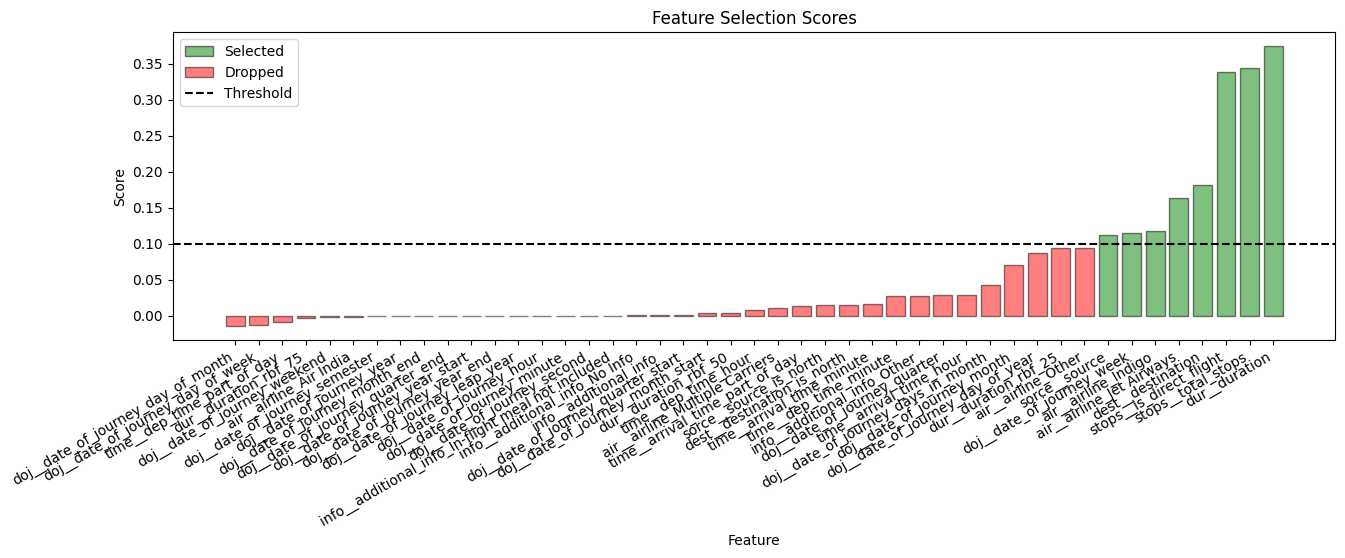

In [41]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

This plot helps you quickly see which features are strong or weak predictors, and which ones are kept or dropped based on your selection threshold.

**How it works**:

- It loops through all features and their R² scores (from sorted_feat_imp).
- For each feature:
   - If the score is below the threshold (0.1), it draws a red bar (dropped feature).
   - If the score is above or equal to the threshold, it draws a green bar (selected feature).
 - It draws a dashed black horizontal line at the threshold value (0.1) to show the cutoff.
 - The x-axis shows feature names, rotated for readability.
 - The y-axis shows the R² score.
 - The legend explains the color coding: green for selected, red for dropped, and the dashed line for the threshold.
 - Finally, it displays the plot.